In [127]:
%matplotlib inline
import numpy as np
import quantstats as qs
import pandas as pd
import yfinance as _yf
from pandas.tseries.offsets import MonthEnd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format

In [45]:
tax_bracket = 0.25
retirement_tax_bracket = 0.15
tax_on_growth = 0.15
retirement_tax_on_growth = 0.0
growth_rate = 0.07
pre_tax_contribution = 18000
early_withdrawal_penalty = 0.10
withdrawal_amount = 9000
post_60_withdrawal_amt = 45000

In [46]:
# invest
invest = {'taxable': pre_tax_contribution * (1-tax_bracket),
          'traditional': pre_tax_contribution,
          'roth': pre_tax_contribution * (1-tax_bracket)}

In [262]:
taxes = pd.DataFrame(dict(age=range(31,41)))
taxes = taxes.merge(pd.DataFrame({'account': ['taxable', 'trad', 'roth']}), how='cross')
# taxes = taxes.merge(pd.DataFrame({'type': ['contribution', 'tax', 'growth']}), how='cross')
taxes = taxes.merge(pd.DataFrame({'type': ['contribution', 'growth', 'tax_enter', 'tax_growth', 'tax_leave']}),how='cross').assign(value=np.nan)
taxes = taxes.pivot(index=['age','type'], columns='account', values='value')
taxes = taxes.loc[:, ['taxable', 'trad', 'roth']]
# taxes

In [263]:
working_period = pd.DataFrame(dict(age=range(31,41))).assign(taxable=np.nan, trad=np.nan, roth=np.nan)
working_period.iloc[0, :] = [working_period['age'].iloc[0], invest['taxable'], invest['traditional'], invest['roth']]
working_period = working_period.set_index('age')
# working_period

In [264]:
for i in working_period.index:
    if i==31:
        taxes.loc[(i, 'contribution')] = [pre_tax_contribution]*3
        taxes.loc[(i, 'growth')] = [0,0,0]
        taxes.loc[(i, 'tax_enter')] = [-1 * pre_tax_contribution * (tax_bracket), 0, -1 * pre_tax_contribution * (tax_bracket)]
        taxes.loc[(i, 'tax_growth')] = [0, 0, 0]
        taxes.loc[(i, 'tax_leave')] = [0, 0, 0]
    else:
        taxes.loc[(i, 'contribution')] = [pre_tax_contribution]*3
        taxes.loc[(i, 'growth')] = growth_rate * working_period.loc[i-1, ['taxable', 'trad', 'roth']]
        taxes.loc[(i, 'tax_enter')] = [-1 * pre_tax_contribution * (tax_bracket), 0, -1 * pre_tax_contribution * (tax_bracket)]
        taxes.loc[(i, 'tax_growth')] = [-1 * (working_period.loc[i-1, 'taxable']*growth_rate*tax_on_growth), 0, 0]
        taxes.loc[(i, 'tax_leave')] = [0, 0, 0]
    if i==31: continue
    working_period.loc[i, 'taxable'] = working_period.loc[i-1, 'taxable'] + (working_period.loc[i-1, 'taxable']*growth_rate*(1-tax_on_growth)) + invest['taxable']
    working_period.loc[i, 'trad'] = working_period.loc[i-1, 'trad'] + (working_period.loc[i-1, 'trad']*growth_rate) + invest['traditional']
    working_period.loc[i, 'roth'] = working_period.loc[i-1, 'roth'] + (working_period.loc[i-1, 'roth']*growth_rate) + invest['roth']
working_period

,taxable,trad,roth
age,,,
31,"13,500.00","18,000.00","13,500.00"
32,"27,803.25","37,260.00","27,945.00"
33,"42,957.54","57,868.20","43,401.15"
34,"59,013.52","79,918.97","59,939.23"
35,"76,024.82","103,513.30","77,634.98"
36,"94,048.30","128,759.23","96,569.42"
37,"113,144.17","155,772.38","116,829.28"
38,"133,376.25","184,676.45","138,507.33"
39,"154,812.14","215,603.80","161,702.85"


In [274]:
cumulative_sum = (
    taxes
    .reset_index()
    .melt(id_vars=['age', 'type'])
    .rename(columns={'value': 'amount'})
    .sort_values('age')
    .set_index(['type', 'account'])
    .assign(cum_sum=lambda df: df.groupby(['type', 'account'])['amount'].cumsum())
    .reset_index()
    .set_index(['age', 'account'])
    .assign(portfolio_value=lambda df: df.groupby(['age', 'account'])['cum_sum'].sum())
    .sort_values(['age', 'account'])
    .reset_index()
    .sort_values(['age', 'type', 'account'])
)
cumulative_sum.head(6)

,age,account,type,amount,cum_sum,portfolio_value
0,31,roth,contribution,"18,000.00","18,000.00","13,500.00"
5,31,taxable,contribution,"18,000.00","18,000.00","13,500.00"
13,31,trad,contribution,"18,000.00","18,000.00","18,000.00"
1,31,roth,growth,0.00,0.00,"13,500.00"
9,31,taxable,growth,0.00,0.00,"13,500.00"
12,31,trad,growth,0.00,0.00,"18,000.00"


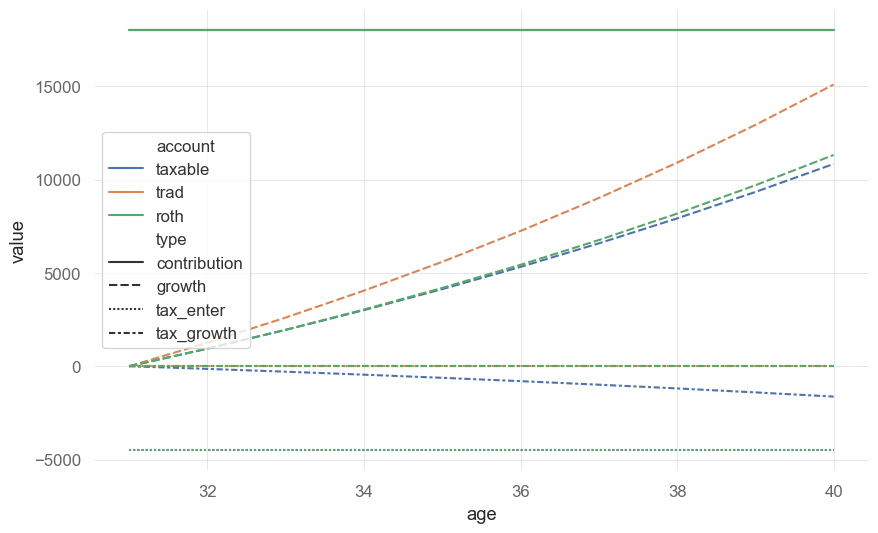

In [162]:
df_long = taxes.reset_index().melt(id_vars=['age', 'type']).query("type != 'tax_leave'")
sns.lineplot(x='age', y='value', hue='account', style='type', data=df_long)
plt.legend()
plt.show()

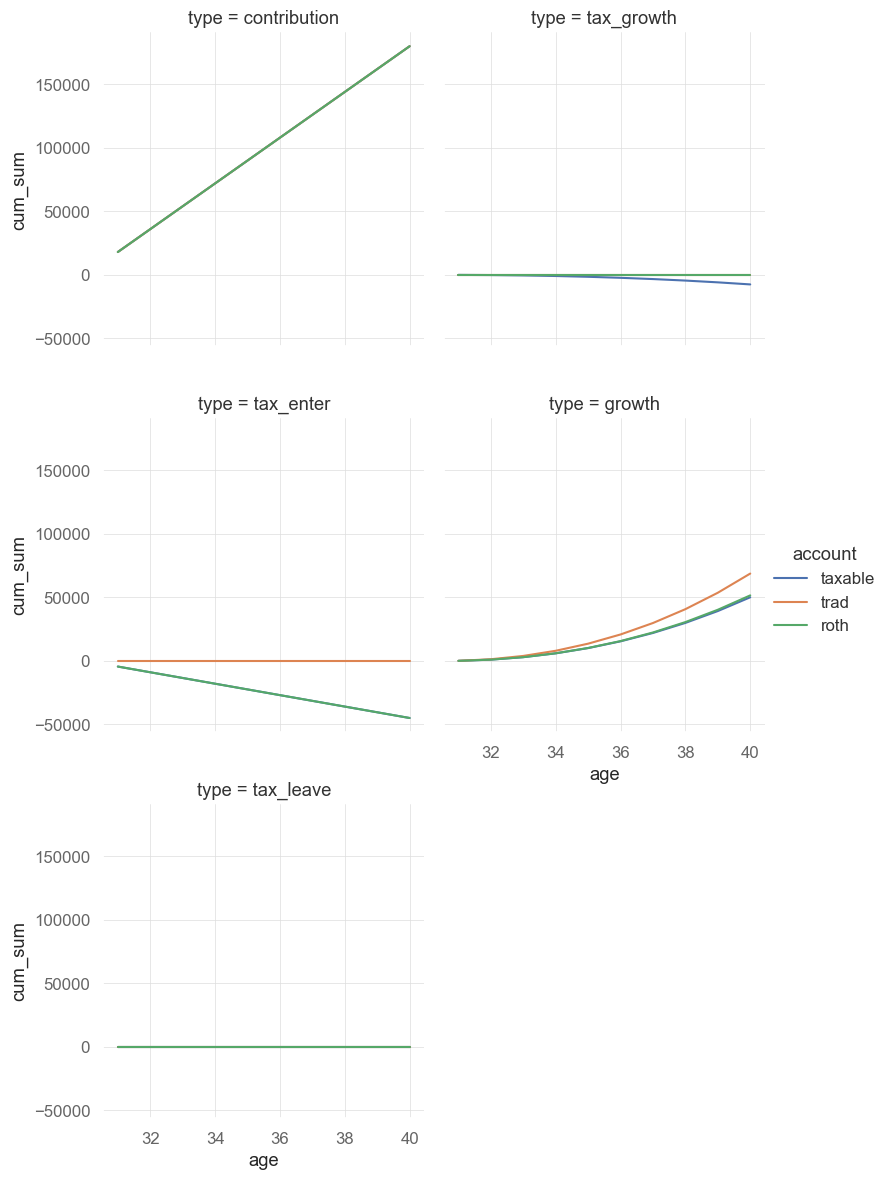

In [252]:
sns.relplot(x="age", y="cum_sum", hue="account", col="type", kind="line", data=cumulative_sum, col_wrap=2, height=4)
plt.show()


In [69]:
# buy and sell in every period, thus paying tax on growth in each period
(1+(growth_rate * (1-tax_on_growth)))**10

1.782418210002834

In [74]:
# buy and hold, so growth is taxed only once at the end
((1+growth_rate)**10 - 1) * (1-tax_on_growth) + 1

1.8220786536961315